In [1]:
import os
import shutil
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Paths and Parameters ---
RAW_DATA_DIR = "D:/datasets/COVID-19_Radiography_Dataset"
DATA_DIR = "D:/datasets/processed_data"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4  # Example: COVID, Lung_Opacity, Normal, Viral Pneumonia
TRAIN_RATIO = 0.8
MODEL_SAVE_PATH = "D:/models/efficientnet_medical.keras"  # Perbaikan di sini

In [3]:
# --- Dataset Organization ---
def organize_dataset(raw_data_dir, data_dir, train_ratio):
    """Organize raw dataset into training and validation folders."""
    categories = os.listdir(raw_data_dir)

    for category in categories:
        category_path = os.path.join(raw_data_dir, category)
        if not os.path.isdir(category_path):
            continue  # Skip if not a folder

        # Create directories for train/validation if not exists
        train_dir = os.path.join(data_dir, "train", category)
        val_dir = os.path.join(data_dir, "validation", category)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)

        # List all images in the category folder
        images = [img for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))]
        split_idx = int(len(images) * train_ratio)

        # Split into training and validation sets
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Copy images to the respective directories
        for img in train_images:
            shutil.copy(
                os.path.join(category_path, img),
                os.path.join(train_dir, img)
            )

        for img in val_images:
            shutil.copy(
                os.path.join(category_path, img),
                os.path.join(val_dir, img)
            )

    print("Dataset organized successfully!")


In [4]:
# --- Dataset Preparation ---
def prepare_dataset(data_dir):
    """Create ImageDataGenerator pipelines for training and validation."""
    train_gen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
    )

    val_gen = ImageDataGenerator(rescale=1.0/255)

    train_data = train_gen.flow_from_directory(
        os.path.join(data_dir, "train"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    val_data = val_gen.flow_from_directory(
        os.path.join(data_dir, "validation"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    return train_data, val_data

# --- Model Definition ---
def build_model(num_classes):
    """Build and compile a model based on EfficientNetB0."""
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [5]:
# --- Visualization ---
def plot_training_history(history):
    """Plot the training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- Training and Evaluation ---
def train_model(model, train_data, val_data, save_path):
    """Train the model and save the best version."""
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(save_path, save_best_only=True, monitor='val_accuracy', mode='max'),
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
    ]

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        callbacks=callbacks
    )

    # Plot training history
    plot_training_history(history)

    return history

def evaluate_model(model, val_data):
    """Evaluate the model on the validation dataset."""
    val_data.reset()
    predictions = model.predict(val_data)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = val_data.classes
    class_labels = list(val_data.class_indices.keys())

    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Mengorganisasi dataset...
Dataset organized successfully!
Menyiapkan dataset...
Found 42330 images belonging to 4 classes.
Found 42330 images belonging to 4 classes.
Membangun model...
Melatih model...


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 2027s 2s/step - accuracy: 0.4848 - loss: 1.1996 - val_accuracy: 0.4815 - val_loss: 1.1866
Epoch 2/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 1607s 1s/step - accuracy: 0.4823 - loss: 1.1868 - val_accuracy: 0.4815 - val_loss: 1.1932
Epoch 3/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 1680s 1s/step - accuracy: 0.4800 - loss: 1.1904 - val_accuracy: 0.4815 - val_loss: 1.1894
Epoch 4/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 2056s 2s/step - accuracy: 0.4813 - loss: 1.1881 - val_accuracy: 0.4815 - val_loss: 1.1883
Epoch 5/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 1632s 1s/step - accuracy: 0.4777 - loss: 1.1924 - val_accuracy: 0.4815 - val_loss: 1.1875
Epoch 6/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 1613s 1s/step - accuracy: 0.4832 - loss: 1.1847 - val_accuracy: 0.4815 - val_loss: 1.1874


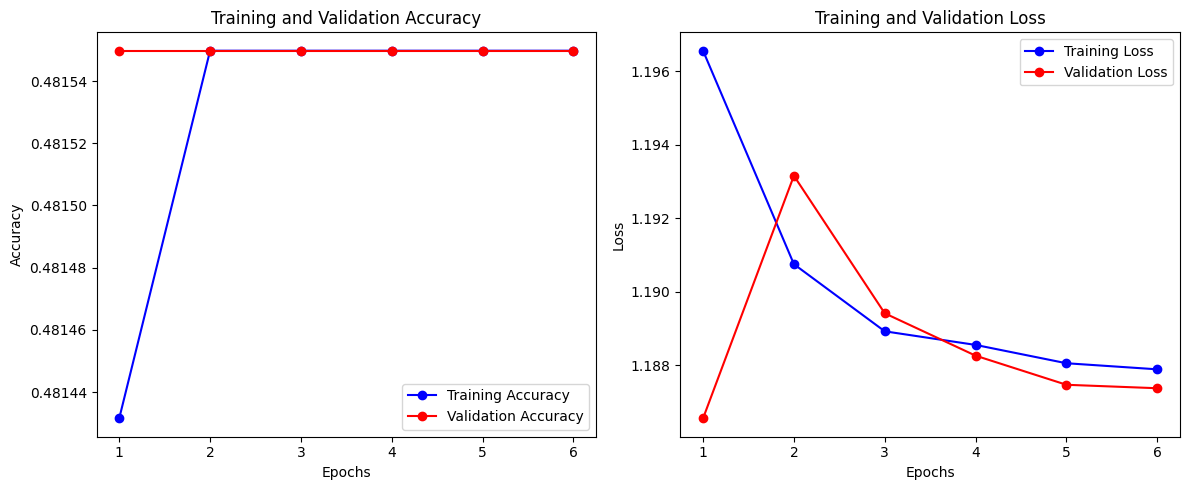

Memuat model terbaik untuk evaluasi...
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 685s 516ms/step

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.00      0.00      0.00      7232
   Lung_Opacity       0.00      0.00      0.00     12024
         Normal       0.48      1.00      0.65     20384
Viral Pneumonia       0.00      0.00      0.00      2690

       accuracy                           0.48     42330
      macro avg       0.12      0.25      0.16     42330
   weighted avg       0.23      0.48      0.31     42330


Confusion Matrix:


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

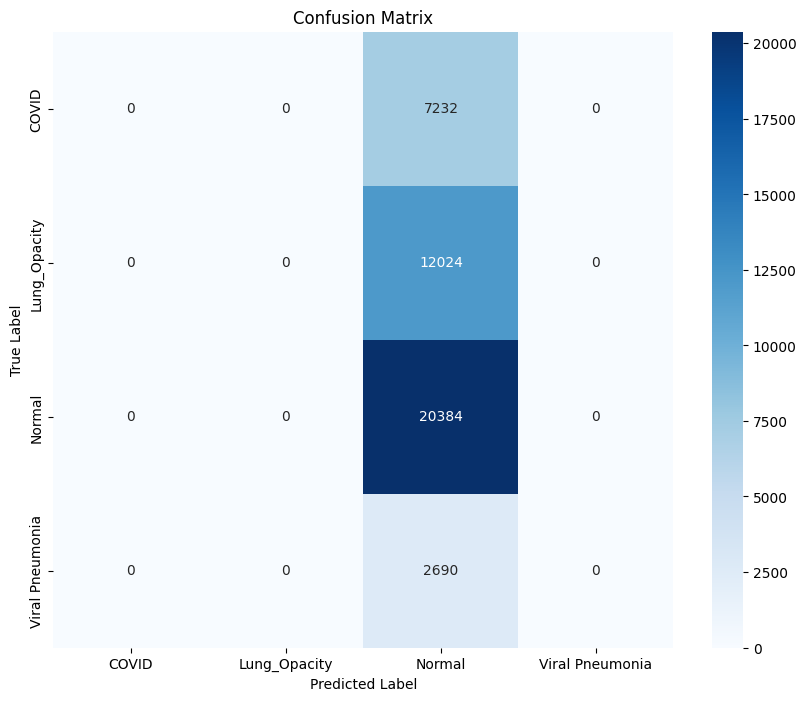

In [6]:
# --- Main Execution ---
def main():
    print("Mengorganisasi dataset...")
    organize_dataset(RAW_DATA_DIR, DATA_DIR, TRAIN_RATIO)

    print("Menyiapkan dataset...")
    train_data, val_data = prepare_dataset(DATA_DIR)

    print("Membangun model...")
    model = build_model(NUM_CLASSES)

    print("Melatih model...")
    train_model(model, train_data, val_data, MODEL_SAVE_PATH)

    print("Memuat model terbaik untuk evaluasi...")
    best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    evaluate_model(best_model, val_data)

if __name__ == "__main__":
    main()
 